In [68]:
from compass import *
import stim
import numpy as np
import pymatching as match
import matplotlib.pyplot as plt

In [5]:
def bacon_shor_group(dimX, dimZ):
    """
    return the BS code stabilizers
    """
    Xs = []
    Zs = []
    for i in range(dimZ-1):
        s = list('_'*dimZ*dimX)
        for j in range(dimX):
            s[j*dimZ+i] = 'Z'
            s[j*dimZ+i+1] = 'Z'
        Zs.append(''.join(s))
    for i in range(dimX-1):
        s = list('_'*dimX*dimZ)
        for j in range(dimZ):
            s[j+i*dimZ] = 'X'
            s[j+(i+1)*dimZ] = 'X'
        Xs.append(''.join(s))
    return [Xs, Zs]

def bsgauge_group(dimX, dimZ):
    """
    return the gauge group generators for the BS code
    """
    Xs = []
    Zs = []
    # make X-type gauge ops
    for i in range(0, dimZ):
        for j in range(dimX-1):
            s = list('_'*dimX*dimZ)
            s[i+j*dimZ] = 'X'
            s[i+(j+1)*dimZ] = 'X'
            Xs.append(''.join(s))
    # make Z-type gauge ops
    for j in range(dimZ-1):
        for i in range(0, dimX): 
            s = list('_'*dimX*dimZ)
            s[i*dimZ+j] = 'Z'
            s[i*dimZ+j+1] = 'Z'
            Zs.append(''.join(s))
    return [Xs, Zs]

In [20]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red ~ -1
    Blue ~ +1
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ['X']*dimX+['_']*dimX*(dimZ-1)
        self.Lz = (['Z']+['_']*(dimX-1))*dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    face_string += ' | '+colored(' # ', 'red')
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    face_string += ' | '+colored(' # ', 'blue')
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Stabilizer dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
            
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[i + k*dimZ] = 'Z'
                gauge[i + k*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimX):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        

In [21]:
def pauli2binary(pstr):
    """
    convert pstr to a binary vector
    """
    bstr = [0]*2*len(pstr)
    for idx, c in enumerate(pstr):
        if c == 'X':
            bstr[idx] = 1
        elif c == 'Z':
            bstr[idx+len(pstr)] = 1
        elif c == 'Y':
            bstr[idx] = 1
            bstr[idx+len(pstr)] = 1
    return np.array(bstr)

---

0) Make Tableau
1) Sample error
2) Find syndrome
3) Decode
4) Check if correction operation commutes with stabs

https://github.com/quantumlib/Stim

In [70]:
class StimWrapper():
    def __init__(self, lattice):
        self.lat = lattice
        self.stabs = []
        for s in lattice.getS():
            self.stabs.append(stim.PauliString(s))
    def syndrome(self, error):
        syn = []
        for s in self.stabs:
            if s.commutes(stim.PauliString(error)):
                syn.append(0)
            else:
                syn.append(1)
        return syn
    def logical_check(self, pauli):
        if ( pauli.commutes(stim.PauliString(''.join(self.lat.Lx))) and 
            pauli.commutes(stim.PauliString(''.join(self.lat.Lz)))):
            return True
        else: 
            return False
    def test(self, hist):
        
        # setup MWPM decoder
        Sx = self.lat.getSx()
        Sz = self.lat.getSz()
        Hx = np.array([[1 if i != '_' else 0 for i in s] for s in Sx])
        Hz = np.array([[1 if i != '_' else 0 for i in s] for s in Sz])
        Mx = Matching(Hx)
        Mz = Matching(Hz)
        
        r_failure = 0
        
        for error in hist.keys():
            syn = self.syndrome(error)
            cx = Mx.decode(syn[:len(Sx)])
            cz = Mz.decode(syn[len(Sx):])
            Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
            Rz = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cz]))
            recovery = Rx*Rz
            corrected = recovery*stim.PauliString(error)
            if self.logical_check(corrected) is False:
                r_failure += hist[error]
        return r_failure

In [71]:
N = 10**4
lat = Lattice2D(6, 7)
slat = StimWrapper(lat)
hist = sample_globalbias(25, 0.0001, 0.001, 0.001, N)
slat.test(hist)

0.021500000000000002

---

# landscape exploration

In [75]:
def str2color(string):
    RGB = np.array([0., 0., 0.])
    for idx, c in enumerate(string):
        if c == -1:
            RGB += (1/2**(idx+1))*np.array([1, 0, 0])
        elif c == 1:
            RGB += (1/2**(idx+1))*np.array([0, 0, 1])
        elif c == 0:
            RGB += (1/2**(idx+1))*np.array([1, 1, 1])
    return RGB

<function matplotlib.pyplot.show(close=None, block=None)>

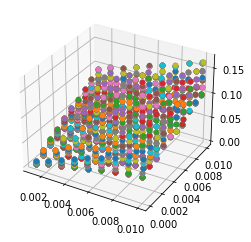

In [84]:
N = 10**4
dim = 3
color_set = [i for i in itt.product([-1, 0, 1], repeat=(dim-1)**2)]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
lattices = []
for c in color_set:
    lat = Lattice2D(dim,dim)
    lat.color_lattice(c)
    lattices.append(StimWrapper(lat))
    
    
for p in np.linspace(0.0, 0.01, 10):
    for q in np.linspace(0.0, 0.01, 10):
        if p == 0 and q == 0: 
            break
        hist = sample_globalbias(dim**2, q, q, p, N)
        for lat in lattices:
            r_failure = lat.test(hist)
            ax.scatter(p, q, r_failure)
plt.show